In [551]:
#import user modules
import helper_functions as hfun
import config as cf
import importlib
importlib.reload(hfun)
importlib.reload(cf)

#--- importet in user module
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.markers import MarkerStyle
import os
from utils import exit
from os import sep as kPSep
from os.path import exists

#--- other modules
import numpy as np
import itertools
import seaborn as sns
import pandas as pd
import math
import random
import imageio
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from scipy.optimize import curve_fit
from joblib import Parallel, delayed
import copy
#plt.style.use(['science','ieee','no-latex'])

# get all the colors
import matplotlib.colors as mcolors
from scipy.special import binom
import sympy as sym

print(cf.base_directory)


user_settings = getattr(cf.plot_settings, 'settings')

../results/Heisenberg/disorder/PBC/


In [552]:

#--- SET SCALING RANGES AND DATA
x0 = 0.1
xend = 1.0
dx = 0.1
length = int((xend-x0) / dx) + 1

def get_scaling_array(settings = None):
    if settings == None:
        settings = user_settings
    vals = []
    if settings['scaling_idx'] == 0:
        if cf.hamiltonian: vals = range(10, 17, 2)
        else: vals = range(11, 17, 1)
    elif cf.model and settings['scaling_idx'] == 4:
        vals = range(0, cf.params_arr[0])
    else :
        for x in range(0, length) :
            vals.append(x0 + x * dx)
    return np.array(vals)

def plot_spectral(axis, dir = "", settings = None, xlab = None, ylab = None, yscale=None, xscale=None, func_x=None, func_y=None):
    #-- main settings
    if settings == None:
        settings = user_settings
    #-- labels
    if xlab == None:
        xlab = "x"
    if ylab == None:
        ylab = "x"
    #-- axis scales
    if xscale != None:
        settings['x_scale'] = xscale
    if yscale != None:
       settings['y_scale'] = yscale
    #-- axis rescaling
    if func_x == None:
        func_x = lambda x, a: x
    if func_y == None:
        func_y = lambda y, a: y
    param_copy = copy.deepcopy(cf.params_arr)

    #--- prepare scaling - axis
    vals = get_scaling_array(settings=settings)

    y_min = 1.0e10;     y_max = -1.0e10;
    x_min = 1.0e10;     x_max = -1.0e10;
    #--- load data and plot one-by-one
    wH = []
    LTA = []
    for x in vals:
        cf.params_arr[settings['scaling_idx']] = x
        if settings['scaling_idx'] == 3 and cf.J0 == 0 and cf.g0 == 0:
            cf.params_arr[4] = int(100 * x / 2.) / 100.
        filename = dir + cf.op_name + hfun.info_param(cf.params_arr)
        if exists(filename):
            data = pd.read_table(filename, sep="\t", header=None)
            xdata = func_x(data[0], x)
            ydata = func_y(data[1], x)
            wH.append(data[2][0])
            idx = min(range(len(xdata)), key=lambda i: abs(xdata[i] - data[2][0]))
            LTA.append(ydata[idx])
            axis.plot(xdata, ydata, label=hfun.key_title(x, settings))
            
            #-- xy-ranges
            mini = ydata.min();  maxi = ydata.max();
            if mini < y_min and np.isfinite(mini): y_min = mini
            if maxi > y_max and np.isfinite(maxi): y_max = maxi
            mini = xdata.min();  maxi = xdata.max();
            if mini < x_min and np.isfinite(mini): x_min = mini
            if maxi > x_max and np.isfinite(maxi): x_max = maxi

    hfun.set_plot_elements(axis = axis, xlim = (x_min, x_max), 
                                    ylim = (0.95*y_min, 1.05*y_max), ylabel = ylab, xlabel = xlab, settings=settings, font_size=10)
  
    
    title = ""
    if (settings['vs_idx'] == 3 or settings['scaling_idx'] == 3) and cf.J0 == 0 and cf.g0 == 0 and cf.h != 0:
        title = hfun.remove_info(hfun.info_param(cf.params_arr), settings['vs'], settings['scaling'], 'w') + ',w=0.5h'
    else :
        title = hfun.remove_info(hfun.info_param(cf.params_arr), settings['vs'], settings['scaling'])
    if settings['vs_idx'] != 2 :
        try : 
            title = list(title);    title[title.index('g')] = hfun.var_name;   title = "".join(title) # g
            #title = list(title);    title[title.index('g')] = hfun.var_name;   title = "".join(title) # g0
        except ValueError:
                print("not found")
    axis.title.set_text(r"$%s$"%title[1:])

    axis.plot(wH, LTA, linestyle='--', marker='o', color='black')
    #--- reset defaults
    cf.params_arr = param_copy

In [553]:
def plot_agp(axis=None, settings_class = None, which=1):
    
    if which < 1 or which > 3: 
        print("Parameter 'which' entered with illegal value")
        return
    #-- main settings
    if settings_class == None:
        settings_class = cf.plot_settings
    settings = getattr(settings_class, 'settings')
    dir = cf.base_directory + "AGP" + kPSep + cf.op_name + kPSep;
    param_copy = copy.deepcopy(cf.params_arr)

    #--- prepare scaling - axis
    vals = get_scaling_array(settings=settings)

    y_min = 1.0e10;     y_max = -1.0e10;
    x_min = 1.0e10;     x_max = -1.0e10;
    #--- load data and plot one-by-one
    for x in vals:
        cf.params_arr[settings['scaling_idx']] = x
        if settings['scaling_idx'] == 3 and cf.J0 == 0 and cf.g0 == 0:
            cf.params_arr[4] = int(100 * x / 2.) / 100.
        filename = dir + hfun.remove_info(hfun.info_param(cf.params_arr), settings['vs']) + ".dat"
        
        if exists(filename):
            data = pd.read_table(filename, sep="\t", header=None)
            if "nan" in data[1][1]: continue
            xdata = (np.array(data[0][1:])).astype(np.float)
            ydata = (np.array(data[which][1:])).astype(np.float) / binom(x, x/2)
            axis.plot(xdata, ydata, label=hfun.key_title(x, settings))
            
            #-- xy-ranges
            mini = ydata.min();  maxi = ydata.max();
            if mini < y_min and np.isfinite(mini): y_min = mini
            if maxi > y_max and np.isfinite(maxi): y_max = maxi
            mini = xdata.min();  maxi = xdata.max();
            if mini < x_min and np.isfinite(mini): x_min = mini
            if maxi > x_max and np.isfinite(maxi): x_max = maxi
    ylab = ""
    if which == 1:
        ylab = "||\\mathcal{A}_{%s}||^2 / D"%settings['vs']
    elif which == 2:
        ylab = "\\chi^{typ}_{%s} / D"%settings['vs']
    else:
        ylab = "\\chi_{%s} / D"%settings['vs']
    hfun.set_plot_elements(axis = axis, xlim = (x_min, x_max), 
                                    ylim = (0.95*y_min, 1.05*y_max), ylabel = ylab, xlabel = settings['vs'], settings=settings, font_size=10)
  
    
    title = ""
    if (settings['vs_idx'] == 3 or settings['scaling_idx'] == 3) and cf.J0 == 0 and cf.g0 == 0 and cf.h != 0:
        title = hfun.remove_info(hfun.info_param(cf.params_arr), settings['vs'], settings['scaling'], 'w') + ',w=0.5h'
    else :
        title = hfun.remove_info(hfun.info_param(cf.params_arr), settings['vs'], settings['scaling'])
    if settings['vs_idx'] != 2 :
        try : 
            title = list(title);    title[title.index('g')] = hfun.var_name;   title = "".join(title) # g
            #title = list(title);    title[title.index('g')] = hfun.var_name;   title = "".join(title) # g0
        except ValueError:
                print("not found")
    axis.title.set_text(r"$%s$"%title[1:])

    #--- reset defaults
    cf.params_arr = param_copy

# PLOT SPECTRAL FUNCTIONS

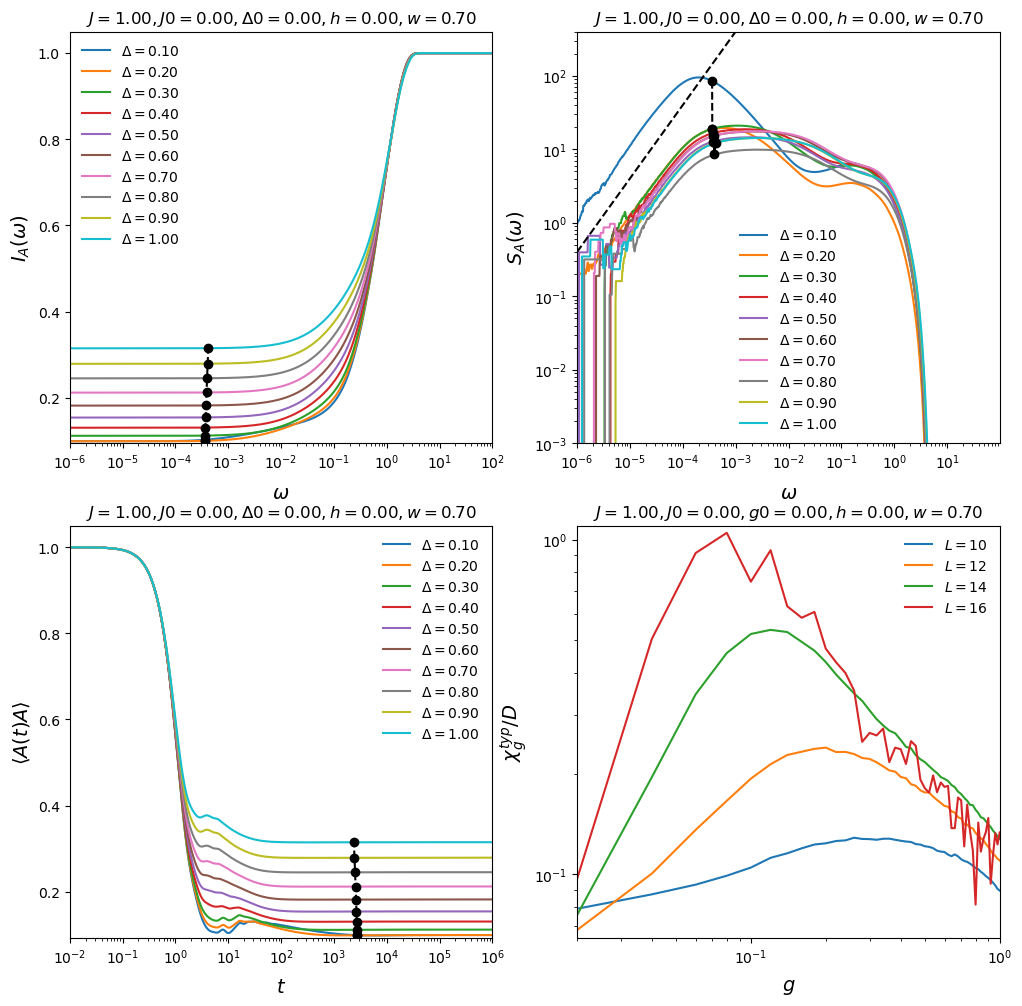

In [554]:
use_derivative = 1

time_dir = cf.base_directory + "timeEvolution%s"%kPSep + cf.subdir
int_dir = cf.base_directory + "IntegratedResponseFunction%s"%kPSep + cf.subdir
spec_dir = cf.base_directory + ("IntegratedResponseFunction%sDERIVATIVE%s"%(kPSep,kPSep) if use_derivative else "ResponseFunction%s"%kPSep) + cf.subdir
agp_dir = cf.base_directory + "AGP{kPSep}" + cf.op_name + kPSep;

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots( nrows=2, ncols=2, figsize=(12,12), dpi = 100)

#---------------------- TIME EVOLUTION
plot_spectral(axis = ax3, dir = time_dir, settings=user_settings, xlab="t", ylab="\\langle A(t)A\\rangle", yscale='linear')


#---------------------- SPECTRAL FUNCTION
func = lambda y, x: y * x**2.0
plot_spectral(axis = ax2, dir = spec_dir, settings=user_settings, xlab="\\omega", ylab="S_A(\\omega)", yscale='log')
ax2.set_ylim(1e-3, 4e2)
xval=np.logspace(-6,-3,100)
ax2.plot(xval, 4e5*xval, linestyle='--', color='black')


#---------------------- INTEGRATED SPECTRAL FUNCTION
plot_spectral(axis = ax1, dir = int_dir, settings=user_settings, xlab="\\omega", ylab="I_A(\\omega)", yscale='linear')

#---------------------- ADIABATICS
new_set_class = copy.deepcopy(cf.plot_settings)
new_set_class.set_vs(cf.plot_settings.settings['scaling'])
new_set_class.set_scaling("L")
new_set_class.set_scales(xscale='log', yscale='log')
plot_agp(axis = ax4, settings_class=new_set_class, which=2)
#ax4.set_ylim(1e-2, 3e0)